In [1]:
import io
import os
import requests
import pathlib
import gzip
import imageio
import pandas as pd


def tif_gzip_to_png(tif_path):
    '''Function to convert .tif.gz to .png and put it in the same folder
    Eg. for working in local work station
    '''
    png_path = pathlib.Path(tif_path.replace('.tif.gz','.png'))
    tf = gzip.open(tif_path).read()
    img = imageio.imread(tf, 'tiff')
    imageio.imwrite(png_path, img)
    
def download_and_convert_tifgzip_to_png(url, target_path):    
    '''Function to convert .tif.gz to .png and put it in the same folder
    Eg. in Kaggle notebook
    '''
    r = requests.get(url)
    f = io.BytesIO(r.content)
    tf = gzip.open(f).read()
    img = imageio.imread(tf, 'tiff')
    imageio.imwrite(target_path, img)

In [2]:
# All label names in the public HPA and their corresponding index. 
all_locations = dict({
    "Nucleoplasm": 0,
    "Nuclear membrane": 1,
    "Nucleoli": 2,
    "Nucleoli fibrillar center": 3,
    "Nuclear speckles": 4,
    "Nuclear bodies": 5,
    "Endoplasmic reticulum": 6,
    "Golgi apparatus": 7,
    "Intermediate filaments": 8,
    "Actin filaments": 9,
    "Focal adhesion sites": 9,
    "Microtubules": 10,
    "Mitotic spindle": 11,
    "Centrosome": 12,
    "Centriolar satellite": 12,
    "Plasma membrane": 13,
    "Cell Junctions": 13,
    "Mitochondria": 14,
    "Aggresome": 15,
    "Cytosol": 16,
    "Vesicles": 17,
    "Peroxisomes": 17,
    "Endosomes": 17,
    "Lysosomes": 17,
    "Lipid droplets": 17,
    "Cytoplasmic bodies": 17,
    "No staining": 18
})


def add_label_idx(df, all_locations):
    '''Function to convert label name to index
    '''
    df["Label_idx"] = None
    for i, row in df.iterrows():
        labels = row.Label.split(',')
        idx = []
        for l in labels:
            if l in all_locations.keys():
                idx.append(str(all_locations[l]))
        if len(idx)>0:
            df.loc[i,"Label_idx"] = "|".join(idx)
            
        print(df.loc[i,"Label"], df.loc[i,"Label_idx"])
    return df

In [3]:
public_hpa_df = pd.read_csv('kaggle_2021.tsv')
# Remove all images overlapping with Training set
public_hpa_df = public_hpa_df[public_hpa_df.in_trainset == False]

# Remove all images with only labels that are not in this competition
public_hpa_df = public_hpa_df[~public_hpa_df.Label_idx.isna()]

colors = ['blue', 'red', 'green', 'yellow']
celllines = ['A-431', 'A549', 'EFO-21', 'HAP1', 'HEK 293', 'HUVEC TERT2', 'HaCaT', 'HeLa', 'PC-3', 'RH-30', 'RPTEC TERT1', 'SH-SY5Y', 'SK-MEL-30', 'SiHa', 'U-2 OS', 'U-251 MG', 'hTCEpi']
public_hpa_df_17 = public_hpa_df[public_hpa_df.Cellline.isin(celllines)]
len(public_hpa_df), len(public_hpa_df_17)

(77668, 67462)

In [5]:
save_dir = os.path.join(os.getcwd(),'publichpa')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for i, row in public_hpa_df[5:10].iterrows():
    try:
        img = row.Image
        for color in colors:
            img_url = f'{img}_{color}.tif.gz'
            save_path = os.path.join(save_dir,  f'{os.path.basename(img)}_{color}.png')
            download_and_convert_tifgzip_to_png(img_url, save_path)
            print(f'Downloaded {img_url} as {save_path}')    
    except:
        print(f'failed to download: {img}')

Downloaded https://images.proteinatlas.org/10005/931_B9_2_blue.tif.gz as C:\Users\PScout\Github\Cell_Recognition_Machine_Learning\publichpa\931_B9_2_blue.png
Downloaded https://images.proteinatlas.org/10005/931_B9_2_red.tif.gz as C:\Users\PScout\Github\Cell_Recognition_Machine_Learning\publichpa\931_B9_2_red.png
Downloaded https://images.proteinatlas.org/10005/931_B9_2_green.tif.gz as C:\Users\PScout\Github\Cell_Recognition_Machine_Learning\publichpa\931_B9_2_green.png
Downloaded https://images.proteinatlas.org/10005/931_B9_2_yellow.tif.gz as C:\Users\PScout\Github\Cell_Recognition_Machine_Learning\publichpa\931_B9_2_yellow.png
Downloaded https://images.proteinatlas.org/10007/1876_A7_32_blue.tif.gz as C:\Users\PScout\Github\Cell_Recognition_Machine_Learning\publichpa\1876_A7_32_blue.png
Downloaded https://images.proteinatlas.org/10007/1876_A7_32_red.tif.gz as C:\Users\PScout\Github\Cell_Recognition_Machine_Learning\publichpa\1876_A7_32_red.png
Downloaded https://images.proteinatlas.org

In [6]:
# ! pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

In [6]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
import glob

mt = glob.glob(save_dir + '/' + '*_red.png')
er = [f.replace('red', 'yellow') for f in mt]
nu = [f.replace('red', 'blue') for f in mt]
images = [mt, er, nu]


NUC_MODEL = "./nuclei-model.pth"
CELL_MODEL = "./cell-model.pth"
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=False,
    multi_channel_model=True,
)

# For nuclei
nuc_segmentations = segmentator.pred_nuclei(images[2])

# For full cells
cell_segmentations = segmentator.pred_cells(images)

# post-processing
for i, pred in enumerate(cell_segmentations):
    nuclei_mask, cell_mask = label_cell(nuc_segmentations[i], cell_segmentations[i])
    FOVname = os.path.basename(mt[i]).replace('red','predictedmask')
    imageio.imwrite(os.path.join(save_dir,FOVname), cell_mask) 

No GPU found, using CPU.
C:\Users\PScout\anaconda3\envs\py3_base\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


please compile abn


C:\Users\PScout\anaconda3\envs\py3_base\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\PScout\anaconda3\envs\py3_base\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\PScout\anaconda3\envs\py3_base\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original 

In [7]:
public_hpa_df[5:10]

,Image,Label,Cellline,in_trainset,Label_idx
5,https://images.proteinatlas.org/10005/931_B9_2,Cytosol,U-2 OS,False,16
6,https://images.proteinatlas.org/10007/1876_A7_32,Endoplasmic reticulum,ASC TERT1,False,6
7,https://images.proteinatlas.org/10007/1876_A7_37,Endoplasmic reticulum,ASC TERT1,False,6
8,https://images.proteinatlas.org/10007/1901_A10_2,Vesicles,U-2 OS,False,17
9,https://images.proteinatlas.org/10007/1901_A10_3,Vesicles,U-2 OS,False,17


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\PScout\\Github\\Cell_Recognition_Machine_Learning\\publichpa\\1876_A7_32_red.png'

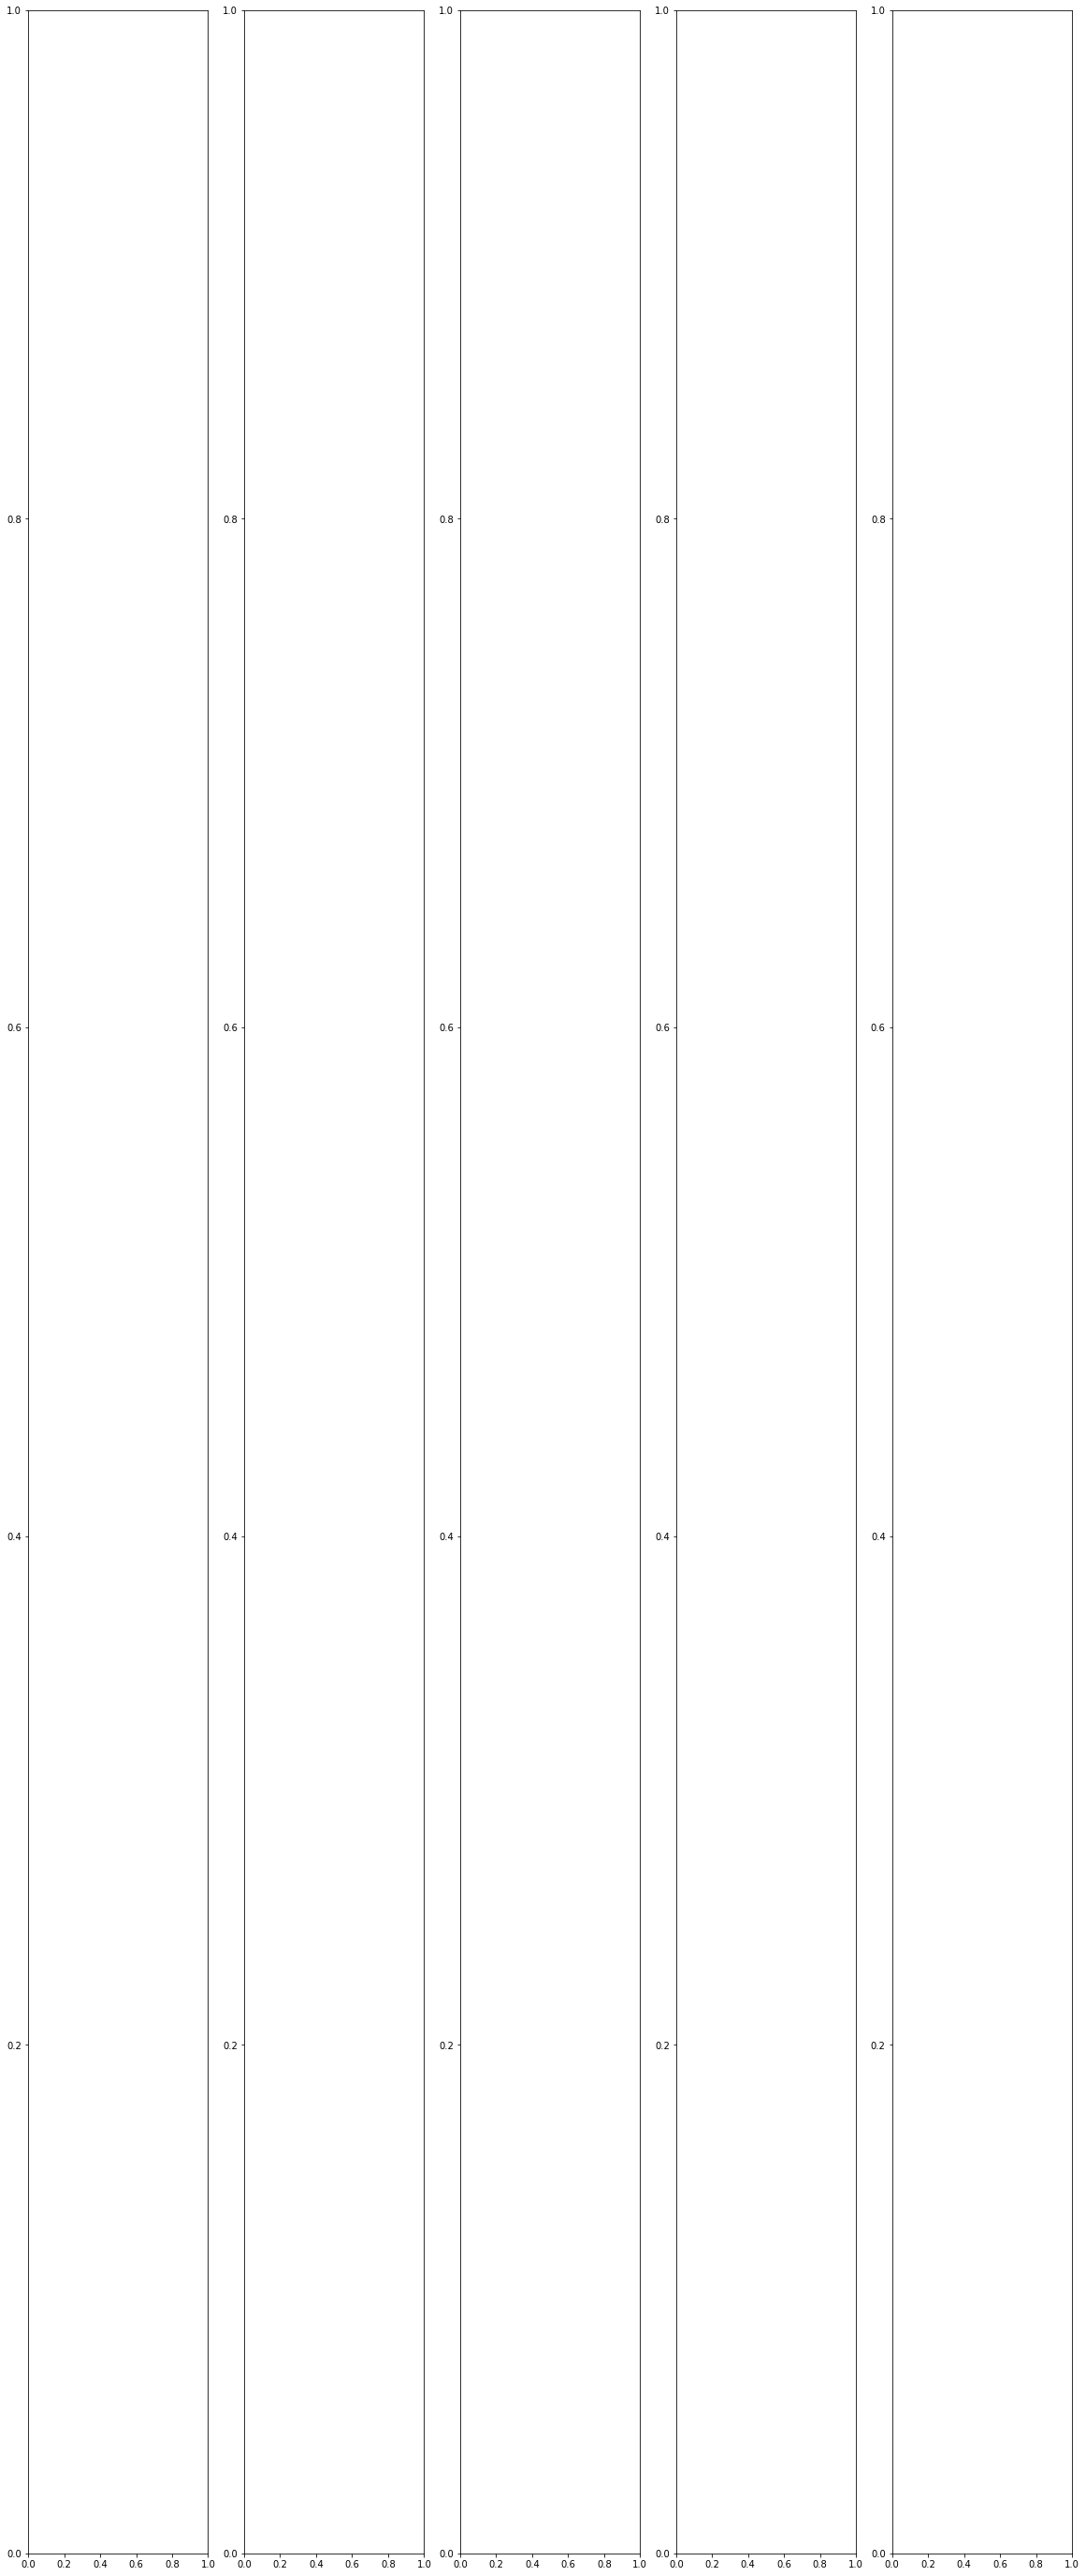

In [9]:
# Visualizing the segmentation masks we just predicted above

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,5, figsize=(20,50))
for i in range(5):
    microtubule = plt.imread(mt[i])    
    endoplasmicrec = plt.imread(er[i])    
    nuclei = plt.imread(nu[i])
    
    
    mask = plt.imread(mt[i].replace('red','predictedmask'))
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    
    ax[i].imshow(img)
    ax[i].imshow(mask, alpha=0.5)
    ax[i].axis('off')
plt.show()